# Vector Extraction

This notebook extracts steering vectors from text pairs using contrastive activation averaging (Chen et al., 2025).

**Method:** For each pair, we capture residual stream activations at each layer using `output_hidden_states`, mean-pool across the sequence dimension (excluding padding tokens), then average across all pairs. The steering vector is the difference: `mean(complex) - mean(simple)`.

**Extraction method:** Uses HuggingFace's `output_hidden_states=True` to capture layer activations, with attention mask to exclude padding tokens from mean pooling.

**Parameterization:** Configure the dataset, model, and batch size in the cell below. This notebook can be reused for different datasets (e.g., OneStopEnglish, Wikipedia, or custom pairs).

## Configuration

In [ ]:
# Dataset configuration
DATASET_PATH = '../data/wikipedia_top20_texts.json'  # Path to JSON with text pairs
DATASET_NAME = 'wikipedia'  # Used for output file naming

# Model configuration
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'
MAX_SEQ_LENGTH = 4096  # Truncate texts to this many tokens

# Processing configuration
BATCH_SIZE = 1  # Process this many texts at once (increase for cloud GPUs)
DEVICE = 'auto'  # 'auto', 'cuda', 'mps', or 'cpu'

# Output configuration
OUTPUT_DIR = '../data/vectors'
OUTPUT_FILENAME = f'complexity_{DATASET_NAME}.pt'

## Setup

In [2]:
import json
import os
from datetime import datetime

import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm

# Determine device
if DEVICE == 'auto':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device('cpu')
        print("⚠ Using CPU (this will be slow)")
else:
    device = torch.device(DEVICE)
    print(f"✓ Using device: {device}")

print(f"\nConfiguration:")
print(f"  Dataset: {DATASET_NAME} ({DATASET_PATH})")
print(f"  Model: {MODEL_NAME}")
print(f"  Max sequence length: {MAX_SEQ_LENGTH:,} tokens")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Output: {os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)}")

✓ Using Apple Silicon GPU (MPS)

Configuration:
  Dataset: onestop (../data/onestop_top20_texts.json)
  Model: Qwen/Qwen3-4B-Instruct-2507
  Max sequence length: 4,096 tokens
  Batch size: 1
  Output: ../data/vectors/complexity_onestop.pt


## Load Dataset

In [3]:
# Load text pairs
with open(DATASET_PATH, 'r') as f:
    pairs = json.load(f)

print(f"✓ Loaded {len(pairs)} text pairs")

# Show first pair as sanity check
print(f"\nFirst pair preview:")
first_pair = pairs[0]
print(f"  Low complexity: {first_pair['low_complexity'][:100]}...")
print(f"  High complexity: {first_pair['high_complexity'][:100]}...")

✓ Loaded 20 text pairs

First pair preview:
  Low complexity: When we talk about climate change, we usually just talk about the problem. We usually forget the man...
  High complexity: When it comes to climate change, we have the bad habit of focusing on the first part of the story, t...


## Load Model and Tokenizer

In [4]:
print(f"Loading model: {MODEL_NAME}...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Tokenizer loaded")

# Load model in bfloat16 (memory efficient, hardware-accelerated)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()  # Disable dropout, batch norm, etc.
print(f"✓ Model loaded in bfloat16")

# Get model metadata
n_layers = model.config.num_hidden_layers
hidden_dim = model.config.hidden_size

print(f"\nModel architecture:")
print(f"  Layers: {n_layers}")
print(f"  Hidden dimension: {hidden_dim:,}")
print(f"  Parameters: ~{sum(p.numel() for p in model.parameters()) / 1e9:.1f}B")

Loading model: Qwen/Qwen3-4B-Instruct-2507...
✓ Tokenizer loaded


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded in bfloat16

Model architecture:
  Layers: 36
  Hidden dimension: 2,560
  Parameters: ~4.0B


## Extract Activations

For each text pair, we:
1. Tokenize and truncate to MAX_SEQ_LENGTH
2. Run forward pass with `output_hidden_states=True`
3. Capture hidden states at each layer
4. Mean-pool across sequence dimension, **excluding padding tokens** (attention mask)
5. Accumulate in float32 for numerical stability

In [5]:
# Initialize accumulators (float32 for numerical stability)
low_complexity_sum = torch.zeros(n_layers, hidden_dim, dtype=torch.float32)
high_complexity_sum = torch.zeros(n_layers, hidden_dim, dtype=torch.float32)
low_complexity_count = 0
high_complexity_count = 0

def extract_activations(text):
    """
    Extract mean-pooled activations from a single text.
    
    Uses output_hidden_states and attention mask to properly handle padding.
    
    Returns:
        torch.Tensor: [n_layers, hidden_dim] in float32
    """
    # Tokenize and truncate
    tokens = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding=False,
    ).to(device)
    
    # Forward pass with hidden states capture
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
    
    # outputs.hidden_states is a tuple of (n_layers + 1) tensors
    # Each tensor is [batch_size, seq_len, hidden_dim]
    # Index 0 is embedding layer, indices 1..n_layers are transformer layers
    hidden_states = outputs.hidden_states[1:]  # Skip embedding layer
    
    # Mean-pool across sequence dimension, excluding padding
    # attention_mask tells us which tokens are real (1) vs padding (0)
    attention_mask = tokens['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]
    
    layer_activations = []
    for layer_hidden in hidden_states:
        # Mask out padding, compute mean over real tokens only
        masked = layer_hidden * attention_mask  # Zero out padding positions
        pooled = masked.sum(dim=1) / attention_mask.sum(dim=1)  # [batch, hidden_dim]
        layer_activations.append(pooled.squeeze(0))  # Remove batch dim
    
    # Stack into [n_layers, hidden_dim] and convert to float32
    activations = torch.stack(layer_activations).to(torch.float32).cpu()
    
    return activations

# Process all pairs
print(f"\nExtracting activations from {len(pairs)} pairs...\n")

for pair in tqdm(pairs, desc="Processing pairs"):
    # Extract low complexity
    low_act = extract_activations(pair['low_complexity'])
    low_complexity_sum += low_act
    low_complexity_count += 1
    
    # Extract high complexity
    high_act = extract_activations(pair['high_complexity'])
    high_complexity_sum += high_act
    high_complexity_count += 1

print(f"\n✓ Processed {low_complexity_count} low-complexity texts")
print(f"✓ Processed {high_complexity_count} high-complexity texts")


Extracting activations from 20 pairs...



Processing pairs:   0%|          | 0/20 [00:00<?, ?it/s]


✓ Processed 20 low-complexity texts
✓ Processed 20 high-complexity texts


## Compute Steering Vectors

In [6]:
# Compute means
low_complexity_mean = low_complexity_sum / low_complexity_count
high_complexity_mean = high_complexity_sum / high_complexity_count

# Steering vector = high - low
# Positive coefficient → more complex, negative → simpler
steering_vectors = high_complexity_mean - low_complexity_mean

print(f"✓ Computed steering vectors")
print(f"  Shape: {steering_vectors.shape}")
print(f"  Dtype: {steering_vectors.dtype}")

✓ Computed steering vectors
  Shape: torch.Size([36, 2560])
  Dtype: torch.float32


## Analyze Magnitude by Layer

We compute the L2 norm of each layer's vector to identify the "best" steering layer.

**Steering hypothesis:** The layer with largest magnitude typically shows strongest steering effect. With the `output_hidden_states` extraction method, this is typically layer N-1 (second-to-last layer).

In [7]:
# Compute L2 norm for each layer
layer_norms = torch.norm(steering_vectors, p=2, dim=1)
best_layer = torch.argmax(layer_norms).item()

print(f"\nLayer magnitude analysis:")
print(f"  Best layer: {best_layer} (0-indexed)")
print(f"  Best layer norm: {layer_norms[best_layer]:.4f}")
print(f"\nTop 5 layers by magnitude:")
top_5_indices = torch.argsort(layer_norms, descending=True)[:5]
for rank, idx in enumerate(top_5_indices, 1):
    print(f"  {rank}. Layer {idx.item()}: {layer_norms[idx]:.4f}")

print(f"\nAll layer norms:")
for i, norm in enumerate(layer_norms):
    marker = " ← BEST" if i == best_layer else ""
    print(f"  Layer {i:2d}: {norm:.4f}{marker}")


Layer magnitude analysis:
  Best layer: 34 (0-indexed)
  Best layer norm: 48.4709

Top 5 layers by magnitude:
  1. Layer 34: 48.4709
  2. Layer 33: 40.5529
  3. Layer 32: 36.4650
  4. Layer 31: 33.4562
  5. Layer 30: 31.2420

All layer norms:
  Layer  0: 0.3292
  Layer  1: 0.5278
  Layer  2: 0.7193
  Layer  3: 1.0659
  Layer  4: 1.6303
  Layer  5: 2.1630
  Layer  6: 3.7081
  Layer  7: 3.9033
  Layer  8: 4.0696
  Layer  9: 4.1604
  Layer 10: 4.2434
  Layer 11: 4.2922
  Layer 12: 4.2612
  Layer 13: 4.3211
  Layer 14: 4.3685
  Layer 15: 4.3912
  Layer 16: 5.5022
  Layer 17: 5.7463
  Layer 18: 5.8530
  Layer 19: 6.6301
  Layer 20: 6.7633
  Layer 21: 7.1334
  Layer 22: 8.6998
  Layer 23: 9.5728
  Layer 24: 12.1882
  Layer 25: 13.0525
  Layer 26: 15.9567
  Layer 27: 17.4503
  Layer 28: 18.7921
  Layer 29: 21.2891
  Layer 30: 31.2420
  Layer 31: 33.4562
  Layer 32: 36.4650
  Layer 33: 40.5529
  Layer 34: 48.4709 ← BEST
  Layer 35: 17.6585


## Visualize Magnitude by Layer

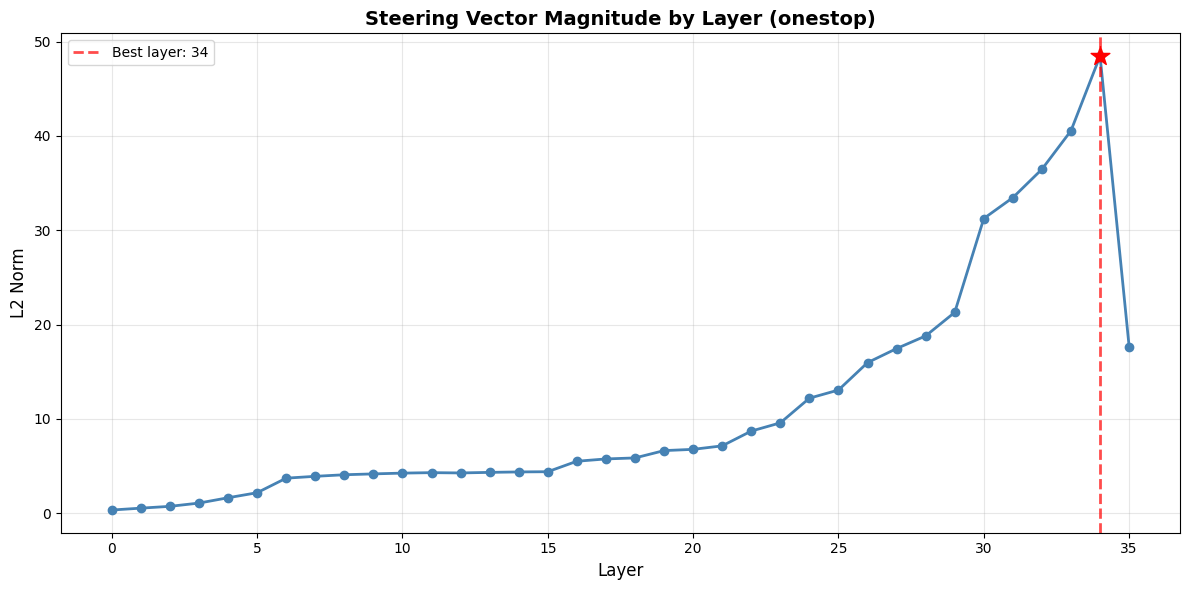


Interpretation:
  The strongest steering vector is near the OUTPUT (layer 34/35).
  This suggests complexity is encoded at the token-selection level.


In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

layers = np.arange(n_layers)
norms = layer_norms.numpy()

ax.plot(layers, norms, 'o-', linewidth=2, markersize=6, color='steelblue')
ax.axvline(best_layer, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best layer: {best_layer}')
ax.scatter([best_layer], [norms[best_layer]], color='red', s=200, zorder=5, marker='*')

ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('L2 Norm', fontsize=12)
ax.set_title(f'Steering Vector Magnitude by Layer ({DATASET_NAME})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
if best_layer >= n_layers - 3:
    print(f"  The strongest steering vector is near the OUTPUT (layer {best_layer}/{n_layers-1}).")
    print(f"  This suggests complexity is encoded at the token-selection level.")
elif best_layer <= 2:
    print(f"  The strongest steering vector is near the INPUT (layer {best_layer}).")
    print(f"  This suggests complexity is encoded early in processing.")
else:
    print(f"  The strongest steering vector is in the MIDDLE layers (layer {best_layer}).")
    print(f"  This suggests complexity is encoded during intermediate processing.")

## Save Vectors

In [9]:
# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Prepare output
output = {
    'vectors': steering_vectors,  # [n_layers, hidden_dim], float32
    'layer_norms': layer_norms,   # [n_layers], float32
    'best_layer': best_layer,     # int
    'metadata': {
        'model': MODEL_NAME,
        'dataset': DATASET_NAME,
        'dataset_path': DATASET_PATH,
        'n_pairs': len(pairs),
        'max_seq_length': MAX_SEQ_LENGTH,
        'n_layers': n_layers,
        'hidden_dim': hidden_dim,
        'extraction_date': datetime.now().isoformat(),
    }
}

# Save
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)
torch.save(output, output_path)

print(f"✓ Saved vectors to {output_path}")
print(f"\nFile contents:")
print(f"  vectors: {steering_vectors.shape} {steering_vectors.dtype}")
print(f"  layer_norms: {layer_norms.shape} {layer_norms.dtype}")
print(f"  best_layer: {best_layer}")
print(f"  metadata: {len(output['metadata'])} fields")

# Compute file size
file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
print(f"\nFile size: {file_size_mb:.2f} MB")

✓ Saved vectors to ../data/vectors/complexity_onestop.pt

File contents:
  vectors: torch.Size([36, 2560]) torch.float32
  layer_norms: torch.Size([36]) torch.float32
  best_layer: 34
  metadata: 8 fields

File size: 0.35 MB


## Verify Saved Vectors

In [10]:
# Load and verify
loaded = torch.load(output_path)

print(f"✓ Successfully loaded {output_path}")
print(f"\nVerification:")
print(f"  Vectors match: {torch.allclose(loaded['vectors'], steering_vectors)}")
print(f"  Norms match: {torch.allclose(loaded['layer_norms'], layer_norms)}")
print(f"  Best layer: {loaded['best_layer']}")
print(f"\nMetadata:")
for key, value in loaded['metadata'].items():
    print(f"  {key}: {value}")

✓ Successfully loaded ../data/vectors/complexity_onestop.pt

Verification:
  Vectors match: True
  Norms match: True
  Best layer: 34

Metadata:
  model: Qwen/Qwen3-4B-Instruct-2507
  dataset: onestop
  dataset_path: ../data/onestop_top20_texts.json
  n_pairs: 20
  max_seq_length: 4096
  n_layers: 36
  hidden_dim: 2560
  extraction_date: 2025-10-26T08:57:27.128685


## Summary

Vector extraction complete! 🎉

To extract vectors from a different dataset:
1. Change `DATASET_PATH` and `DATASET_NAME` in the configuration cell
2. Restart kernel and run all cells

For example:
```python
DATASET_PATH = '../data/wikipedia_top20_texts.json'
DATASET_NAME = 'wikipedia'
```

The steering vectors are now ready for use in steering experiments!